In [1]:
import os
import sys
sys.path.append('../')
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from visdom import Visdom
from tqdm import tqdm
from utils.datasets import ACDCDataset

EXP_NAME = 'fcn-shufflenetv2'
LOG_FILE = EXP_NAME + '.log'
VIS_FILE = EXP_NAME + '.vislog'

def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [2]:
augmentation = albumentations.Compose([
    albumentations.Resize(520, 520),
    albumentations.CLAHE(p=1.),
    albumentations.GridDistortion(p=.5),
    albumentations.ElasticTransform(p=.5),
    albumentations.OpticalDistortion(p=.5),
    albumentations.IAAAffine(p=.5),
    albumentations.RandomRotate90(p=.7),
    albumentations.Transpose(p=.7),
    albumentations.ShiftScaleRotate(p=.7),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=True)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [3]:
len(train_dataset), len(val_dataset)

(1330, 572)

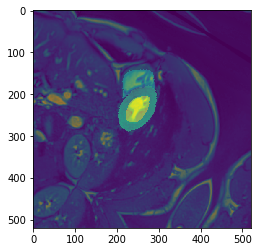

In [4]:
c, img, mask = dataset[70]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
net = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
net.conv1[0] = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'conv5': 'out'})
classifier = torchvision.models.segmentation.fcn.FCNHead(1024, 4)
model = torchvision.models.segmentation.FCN(backbone, classifier).to(device)
model.load_state_dict(torch.load('chckpoints/fcn-shufflenetv2/checkpoints_36.pth'))

<All keys matched successfully>

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = dice_loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [8]:
if not os.path.exists(os.path.join('chckpoints', EXP_NAME)):
    os.makedirs(os.path.join('chckpoints', EXP_NAME))

In [9]:
vis = Visdom(log_to_filename=VIS_FILE, offline=True)
train_losses = np.ones(80)
val_losses = np.ones(80)
for epoch in range(37, 80):
    train_loss = 0.
    val_loss = 0.
    model.train()
    for _, images, targets in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # backpropagate
        pred = model(images)['out']
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_generator)
    torch.cuda.empty_cache()
    model.eval()
    for _, images, targets in tqdm(val_generator, total=len(val_generator)):
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            pred = model(images)['out']
        loss = criterion(pred, targets)
        val_loss += loss.item() / len(val_generator)
    torch.save(model.state_dict(), os.path.join('chckpoints', EXP_NAME, 'checkpoints_%d.pth' % epoch))
    torch.save(optimizer.state_dict(), os.path.join('chckpoints', EXP_NAME, 'optimizer_%d.pth' % epoch))
    scheduler.step(val_loss)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    vis.line(X=[epoch], Y=[train_loss], win='loss curves', name='train', update='append')
    vis.line(X=[epoch], Y=[val_loss], win='loss curves', name='val', update='append')
    vis.line(X=[epoch], Y=[optimizer.param_groups[0]['lr']], win='loss curves', name='lr', update='append')
    print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())))
    with open(LOG_FILE, 'a') as _f:
        print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())), file=_f)
    if optimizer.param_groups[0]['lr'] < 2e-8:
        train_losses = train_losses[:epoch+1]
        val_losses = val_losses[:epoch+1]
        break

  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 37 train loss: 0.109 val loss: 0.121 time: 2020-04-28 01:04:19.657762


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 38 train loss: 0.108 val loss: 0.117 time: 2020-04-28 01:13:12.476574


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 39 train loss: 0.109 val loss: 0.119 time: 2020-04-28 01:22:14.795384


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 40 train loss: 0.106 val loss: 0.116 time: 2020-04-28 01:30:32.676570


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 41 train loss: 0.106 val loss: 0.116 time: 2020-04-28 01:38:54.831720


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 42 train loss: 0.107 val loss: 0.117 time: 2020-04-28 01:47:35.372943


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 43 train loss: 0.106 val loss: 0.118 time: 2020-04-28 01:56:25.245619


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 44 train loss: 0.107 val loss: 0.115 time: 2020-04-28 02:05:28.298201


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 45 train loss: 0.105 val loss: 0.113 time: 2020-04-28 02:14:43.074242


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 46 train loss: 0.104 val loss: 0.116 time: 2020-04-28 02:23:40.007137


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 47 train loss: 0.106 val loss: 0.115 time: 2020-04-28 02:32:38.463530


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 48 train loss: 0.105 val loss: 0.112 time: 2020-04-28 02:41:30.406553


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 49 train loss: 0.103 val loss: 0.111 time: 2020-04-28 02:50:27.215053


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 51 train loss: 0.103 val loss: 0.108 time: 2020-04-28 03:08:06.860427


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 52 train loss: 0.103 val loss: 0.113 time: 2020-04-28 03:17:05.092292


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 53 train loss: 0.102 val loss: 0.112 time: 2020-04-28 03:26:05.509726


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 54 train loss: 0.103 val loss: 0.112 time: 2020-04-28 03:35:17.688826


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-05.
epoch: 55 train loss: 0.101 val loss: 0.113 time: 2020-04-28 03:44:13.514577


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 56 train loss: 0.103 val loss: 0.113 time: 2020-04-28 03:53:00.097375


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 57 train loss: 0.101 val loss: 0.113 time: 2020-04-28 04:02:04.623691


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 58 train loss: 0.100 val loss: 0.112 time: 2020-04-28 04:10:50.532913


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch    22: reducing learning rate of group 0 to 1.0000e-06.
epoch: 59 train loss: 0.101 val loss: 0.112 time: 2020-04-28 04:19:40.581049


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 60 train loss: 0.101 val loss: 0.108 time: 2020-04-28 04:28:40.466809


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 61 train loss: 0.100 val loss: 0.110 time: 2020-04-28 04:37:40.964220


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 62 train loss: 0.100 val loss: 0.111 time: 2020-04-28 04:46:39.374777


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 63 train loss: 0.100 val loss: 0.111 time: 2020-04-28 04:55:23.090151


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch    27: reducing learning rate of group 0 to 1.0000e-07.
epoch: 64 train loss: 0.103 val loss: 0.113 time: 2020-04-28 05:04:29.018394


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 65 train loss: 0.100 val loss: 0.110 time: 2020-04-28 05:13:12.929067


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 66 train loss: 0.100 val loss: 0.112 time: 2020-04-28 05:22:16.306678


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 67 train loss: 0.100 val loss: 0.112 time: 2020-04-28 05:30:54.058900


100%|██████████| 18/18 [02:38<00:00,  8.82s/it]


Epoch    31: reducing learning rate of group 0 to 1.0000e-08.
epoch: 68 train loss: 0.099 val loss: 0.112 time: 2020-04-28 05:39:59.678958


In [29]:
model.load_state_dict(torch.load('chckpoints/fcn-shufflenetv2/checkpoints_60.pth'))

<All keys matched successfully>

In [30]:
torch.cuda.empty_cache()

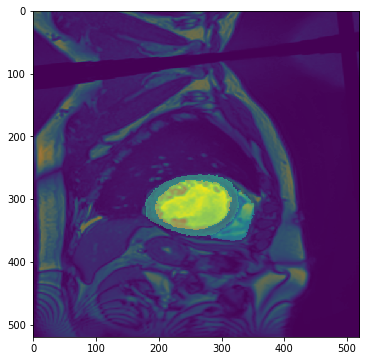

In [31]:
c, img, mask = val_dataset[59]

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

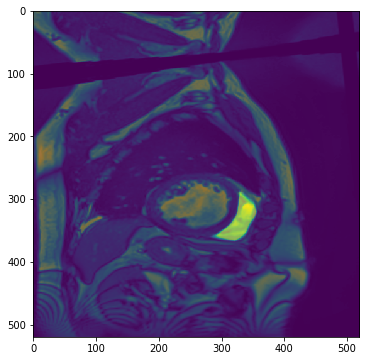

In [32]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))['out'][0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[1], alpha=0.5)
plt.show()

In [33]:
torch.save(model, 'fcn-shufflenetV2.pth')